# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [ ]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int):
    pk = []
    apk = []

    # считаем precision
    for rel, pred in zip(relevant, predicted):
        pk += [np.cumsum(np.isin(pred[:k], rel)) / np.arange(1, k + 1)]

    # считаем average precision
    for rel, pred, pku in zip(relevant, predicted, pk):
        apk += [np.sum(np.isin(pred[:k], rel) * pku) / min(len(rel), k)]

    return np.mean(apk)


In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for uid in range(self.n_users):
            test_preds.append(self.recommend(uid))
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:

    return np.divide(ratings @ user_vector.T,
                     np.sqrt(np.sum(ratings, axis=1))*np.sqrt(np.sum(user_vector))) # нам не обязательно возводить в квадрат элементы суммы под корнем, потому что там 0 и 1


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return np.divide(ratings @ user_vector.T, np.sum((ratings + user_vector) != 0, axis=1)) # в знаменателе объединение перепишем как проверку суммы на равенство 0,
                                                                                            # т.е. если хотя бы один из пользователей прослушал трек, будет 1


def random(ratings: np.array, user_vector: np.array) -> np.array:
    return np.random.rand(ratings.shape[0])


**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func, sparse=False):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard, random]

        self.similarity_func = similarity_func
        self.alpha = 0.02
        self.sparse = sparse

        if self.sparse:
            self.R = scs.csr_matrix(self.R)

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        if self.sparse:
            user_vector = user_vector.toarray()


        return np.asarray(self.similarity_func(self.R,user_vector)).squeeze()

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        mask = np.where(sim > self.alpha)[0]  # маска для фильтрации по альфа
        mask = mask[mask != uid] # убираем прослушанные юзером комозиции из рекомендации

        reс = sim[mask] @ self.R[mask]/np.sum(sim[mask])
        return np.argsort(reс)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

  0%|          | 0/50 [00:00<?, ?it/s]

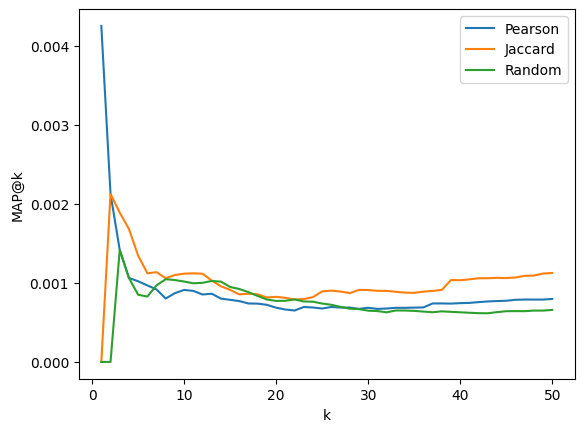

In [ ]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(55)

pearson_model = User2User(train_ratings, pearson)
jaccard_model = User2User(train_ratings, jaccard)
random_model = User2User(train_ratings, random)

pearson_mapk = []
jaccard_mapk = []
random_mapk = []

k_range = 50

pearson_recs = pearson_model.get_test_recommendations(k_range)
jaccard_recs = jaccard_model.get_test_recommendations(k_range)
random_recs = random_model.get_test_recommendations(k_range)

for k in tqdm(range(1, k_range+1)):
    pearson_mapk.append(mapk(test_relevant, pearson_recs, k))
    jaccard_mapk.append(mapk(test_relevant, jaccard_recs, k))
    random_mapk.append(mapk(test_relevant, random_recs, k))

plt.plot(range(1, k_range+1), pearson_mapk, label='Pearson')
plt.plot(range(1, k_range+1), jaccard_mapk , label='Jaccard')
plt.plot(range(1, k_range+1), random_mapk, label='Random')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

  0%|          | 0/50 [00:00<?, ?it/s]

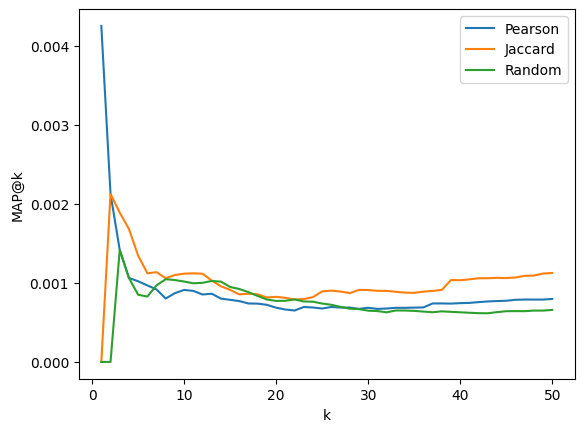

In [ ]:
np.random.seed(55)
sparse_pearson_model = User2User(train_ratings, pearson, True)
sparse_jaccard_model = User2User(train_ratings, jaccard, True)
sparse_random_model = User2User(train_ratings, random, True)

sparse_pearson_mapk = []
sparse_jaccard_mapk = []
sparse_random_mapk = []

sparse_pearson_recs = sparse_pearson_model.get_test_recommendations(k_range)
sparse_jaccard_recs = sparse_jaccard_model.get_test_recommendations(k_range)
sparse_random_recs = sparse_random_model.get_test_recommendations(k_range)

for k in tqdm(range(1, k_range+1)):
    sparse_pearson_mapk.append(mapk(test_relevant, sparse_pearson_recs, k))
    sparse_jaccard_mapk.append(mapk(test_relevant, sparse_jaccard_recs, k))
    sparse_random_mapk.append(mapk(test_relevant, sparse_random_recs, k))

plt.plot(range(1, k_range+1), sparse_pearson_mapk, label='Pearson')
plt.plot(range(1, k_range+1), sparse_jaccard_mapk , label='Jaccard')
plt.plot(range(1, k_range+1), sparse_random_mapk, label='Random')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()
# видим, что графики такие же, значит мы ничего не сломали)

In [ ]:
# Посмотрим на время работы
import time

start_not_sparse = time.time()
pearson_model.get_test_recommendations(k_range)
end_not_sparse = time.time() - start_not_sparse

start_sparse = time.time()
sparse_pearson_model.get_test_recommendations(k_range)
end_sparse = time.time() - start_sparse

print(f'Время работы без разреженных матриц: {end_not_sparse} секунд\nВремя работы с разреженными матрицами {end_sparse} секунд')

Время работы без разреженных матриц: 13.12930679321289 секунд
Время работы с разреженными матрицами 3.1489038467407227 секунд


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
user_id = np.random.randint(0, jaccard_model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
11,Long Tall Sally,['Little Richard']
23,Fortunate Son,['Creedence Clearwater Revival']
33,Beautiful,['Eminem']
62,War,['Edwin Starr']
94,Iron Man,['Black Sabbath']
95,Paranoid,['Black Sabbath']
99,N.I.B.,['Black Sabbath']
189,Sweet Home Alabama,['Lynyrd Skynyrd']
210,Born To Be Wild,['Steppenwolf']
258,What A Wonderful World,['Louis Armstrong']


In [ ]:
preds = sparse_jaccard_model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
32901,Shape of You,['Ed Sheeran']
10792,Rolling In The Deep,['Adele']
49577,Кукла колдуна,['Король и Шут']
418,Without Me,['Eminem']
39265,Beggin',['Måneskin']
419,The Real Slim Shady,['Eminem']
22325,Dancin,"['Aaron Smith', 'Krono', 'Luvli']"
12556,Too Close,['Alex Clare']
32557,Наше лето,['Валентин Стрыкало']
7780,ИСКАЛА,['Земфира']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
62324,Under Pressure,"['A*S*Y*S', 'Belocca']"
62343,BxMxC,['Babymetal']
62612,Забор,['Монгол Шуудан']
62759,Riders On The Storm,"['Snoop Dogg', 'The Doors']"
62760,Teardrops,['Bring Me The Horizon']
62807,Ori Ori,['Manntra']
62882,Kingslayer,"['Bring Me The Horizon', 'Babymetal']"
63070,Сядь мне на лицо,"['Anacondaz', 'кис-кис']"
63086,Вояджер-1,['Noize MC']
63419,Russian Cyberfolk Song,"['Liliana Bush', 'Daria Scherbak', 'Ensemble V..."


Кажется, рекомендации так себе

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**   
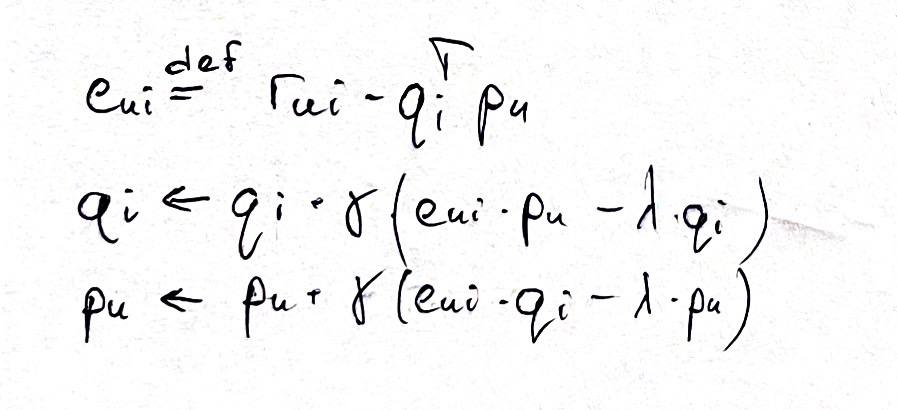

**ALS:**   
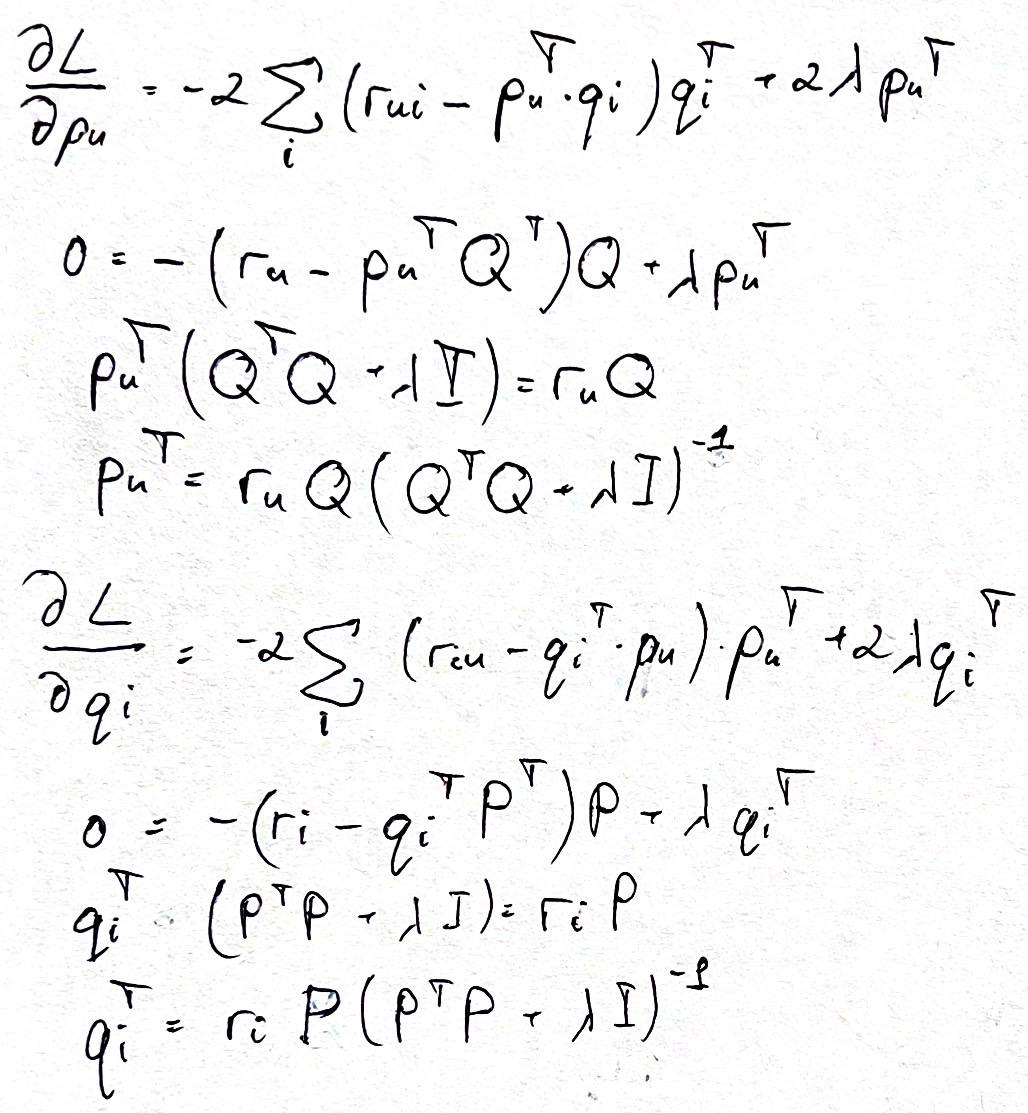

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lr=0.0003, lamb=0.01): # добавила lr, lamb в параметры, чтобы можно было их крутить
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = lr
        self.lamb = lamb

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            u = np.random.randint(0, self.n_users)
            i = np.random.randint(0, self.n_items)
            p = self.P[u, :]
            q = self.Q[i, :]

            if self.mode == 'sgd':
                self.P[u, :] = q + self.lr * (p @ q * p - self.R[u][i] * p + self.lamb * q)
                self.Q[i, :] = p + self.lr * (p @ q * q - self.R[u][i] * q + self.lamb * p)


            elif self.mode == 'als':
                self.P[u, :] = self.R[u][:] @ self.Q @ np.linalg.inv(self.Q.T @ self.Q + self.lamb*np.eye(self.dim))
                self.Q[i, :] = self.R[:, i] @ self.P @ np.linalg.inv(self.P.T @ self.P + self.lamb*np.eye(self.dim))


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
np.random.seed(55)
mapk_dict = {'u2u_pearson': mapk(test_relevant, sparse_pearson_model.get_test_recommendations(10), 10),
             'u2u_jaccard': mapk(test_relevant, sparse_jaccard_model.get_test_recommendations(10), 10),
             'random': mapk(test_relevant, sparse_random_model.get_test_recommendations(10), 10)}
pd.DataFrame(mapk_dict, index=['mapk'])

,u2u_pearson,u2u_jaccard,random
mapk,0.000912,0.001118,0.001018


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

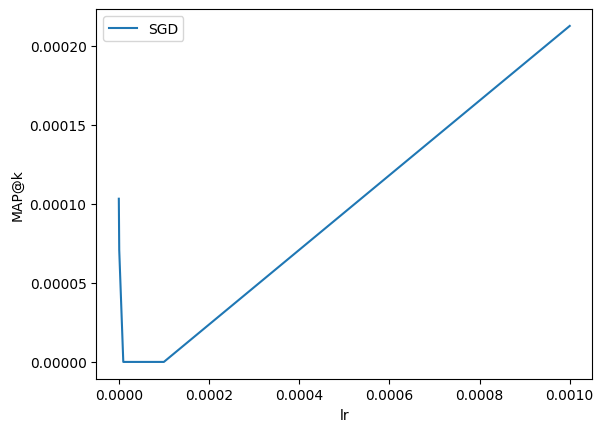

In [ ]:
# подберем learning rate
np.random.seed(55)
sgd_mapk = []
for lr in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]:
  sgd_model = HiddenVars(train_ratings, lr=lr, mode='sgd')
  sgd_model.fit(num_iters=20000)
  result_sgd = sgd_model.get_test_recommendations(10)
  sgd_mapk.append(mapk(test_relevant, result_sgd, 10))

plt.plot([1e-7, 1e-6, 1e-5, 1e-4, 1e-3], sgd_mapk, label='SGD')
plt.ylabel('MAP@k')
plt.xlabel('lr')
plt.legend()
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

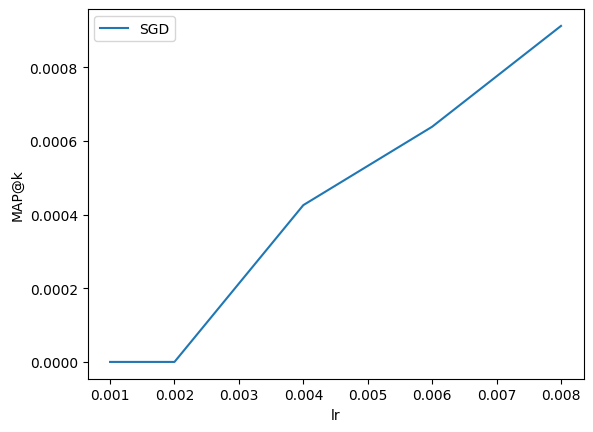

In [ ]:
# более точечно посмотрим на lr:
np.random.seed(55)
sgd_mapk = []
for lr in [1e-3, 2e-3, 4e-3, 6e-3, 8e-3]:
  sgd_model = HiddenVars(train_ratings, lr=lr, mode='sgd')
  sgd_model.fit(num_iters=20000)
  result_sgd = sgd_model.get_test_recommendations(10)
  sgd_mapk.append(mapk(test_relevant, result_sgd, 10))

plt.plot([1e-3, 2e-3, 4e-3, 6e-3, 8e-3], sgd_mapk, label='SGD')
plt.ylabel('MAP@k')
plt.xlabel('lr')
plt.legend()
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

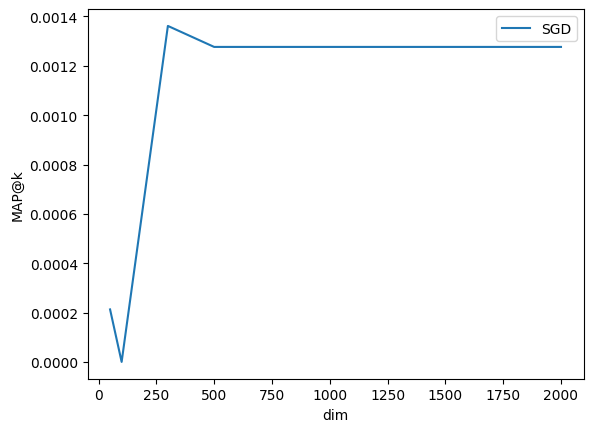

In [ ]:
# посмотрим на разные значения dim
np.random.seed(55)
sgd_mapk = []
for dim in [50, 100, 300, 500, 800, 1000, 1500, 2000]:
  sgd_model = HiddenVars(train_ratings, lr= 0.008, dim=dim, mode='sgd')
  sgd_model.fit(num_iters=20000)
  result_sgd = sgd_model.get_test_recommendations(10)
  sgd_mapk.append(mapk(test_relevant, result_sgd, 10))

plt.plot([50, 100, 300, 500, 800, 1000, 1500, 2000], sgd_mapk, label='SGD')
plt.ylabel('MAP@k')
plt.xlabel('dim')
plt.legend()
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/150000 [00:00<?, ?it/s]

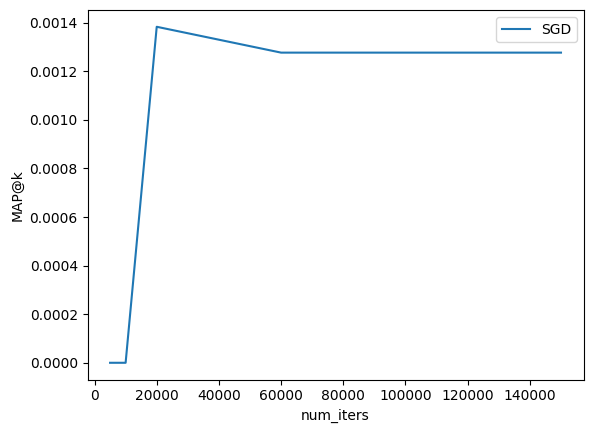

In [ ]:
sgd_mapk = []
for niter in [5000, 10000, 20000, 60000, 100000, 150000]:
  sgd_model = HiddenVars(train_ratings, lr=0.008, dim=300, mode='sgd')
  sgd_model.fit(num_iters=niter)
  result_sgd = sgd_model.get_test_recommendations(10)
  cur_mapk = mapk(test_relevant, result_sgd, 10)
  sgd_mapk.append(cur_mapk)
plt.plot([5000, 10000, 20000, 60000, 100000, 150000], sgd_mapk, label='SGD')
plt.ylabel('MAP@k')
plt.xlabel('num_iters')
plt.legend()
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

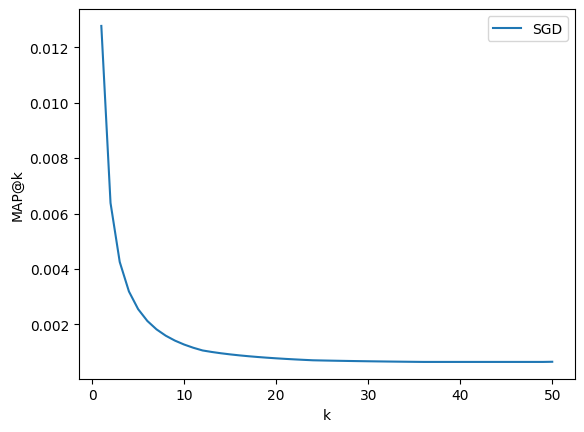

In [ ]:
sgd_mapk = []
sgd_model = HiddenVars(train_ratings, lr=0.008, dim=300, mode='sgd')
sgd_model.fit(num_iters=20000)
result_sgd = sgd_model.get_test_recommendations(50)
for k in tqdm(range(1, 51)):
  sgd_mapk.append(mapk(test_relevant, result_sgd, k))

plt.plot(range(1, 51), sgd_mapk, label='SGD')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

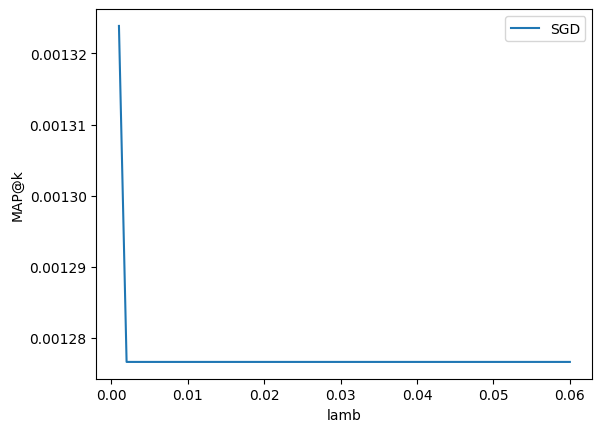

In [ ]:
sgd_mapk = []
for lamb in [0.001, 0.002, 0.005, 0.01, 0.02, 0.06]:
  sgd_model = HiddenVars(train_ratings, lr=0.008, lamb=lamb, dim=300, mode='sgd')
  sgd_model.fit(num_iters=20000)
  result_sgd = sgd_model.get_test_recommendations(10)
  cur_mapk = mapk(test_relevant, result_sgd, 10)
  sgd_mapk.append(cur_mapk)
plt.plot([0.001, 0.002, 0.005, 0.01, 0.02, 0.06], sgd_mapk, label='SGD')
plt.ylabel('MAP@k')
plt.xlabel('lamb')
plt.legend()
plt.show()

In [ ]:
sgd_model = HiddenVars(train_ratings, lr=0.008, dim=300, mode='sgd')
sgd_model.fit(num_iters=20000)
result_sgd = sgd_model.get_test_recommendations(10)
mapk_dict['sgd'] = mapk(test_relevant, result_sgd, 10)
pd.DataFrame(mapk_dict, index=['mapk'])
# побили качество u2ujaccard

  0%|          | 0/20000 [00:00<?, ?it/s]

,u2u_pearson,u2u_jaccard,random,sgd,als
mapk,0.000912,0.001118,0.001018,0.001277,0.000085


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

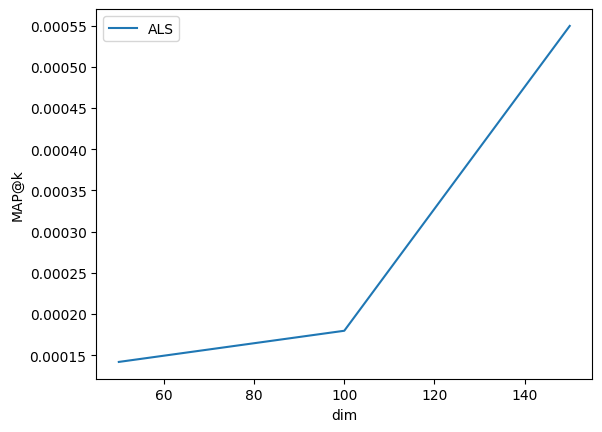

In [ ]:
np.random.seed(55)
als_mapk = []
for dim in [50, 100, 150]:
  als_model = HiddenVars(train_ratings, mode='als', dim=dim, lamb=0.04)
  als_model.fit(num_iters=500)
  result_als = als_model.get_test_recommendations(10)
  als_mapk.append(mapk(test_relevant, result_als, 10))

plt.plot([50, 100, 150], als_mapk, label='ALS')
plt.ylabel('MAP@k')
plt.xlabel('dim')
plt.legend()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

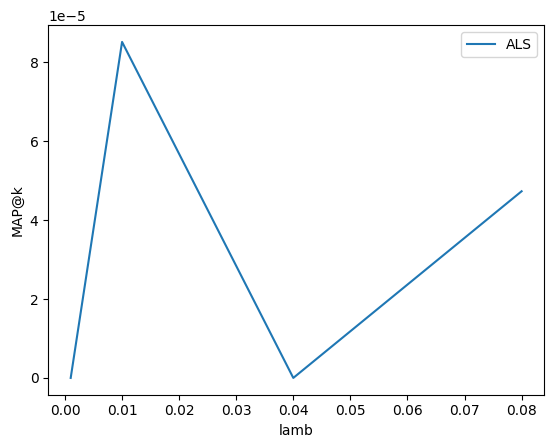

In [ ]:
np.random.seed(55)
als_mapk = []
for lamb in [0.001, 0.01, 0.04, 0.08]:
  als_model = HiddenVars(train_ratings, mode='als', dim=150, lamb=lamb)
  als_model.fit(num_iters=500)
  result_als = als_model.get_test_recommendations(10)
  als_mapk.append(mapk(test_relevant, result_als, 10))
plt.plot([0.001, 0.01, 0.04, 0.08], als_mapk, label='ALS')
plt.ylabel('MAP@k')
plt.xlabel('lamb')
plt.legend()
plt.show()

In [ ]:
np.random.seed(55)
mapk_dict['als'] = als_mapk[1]
pd.DataFrame(mapk_dict, index=['mapk'])

,u2u_pearson,u2u_jaccard,random,sgd,als
mapk,0.000912,0.001118,0.001018,0.001277,0.000085


Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = sgd_model.Q @ sgd_model.Q[example_trackId]
preds = preds / np.sqrt((sgd_model.Q**2).sum(axis=1) + 1e-8)

preds = preds[~np.isnan(preds)]

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(sgd_model.Q[example_trackId])
similar_tracks
# получилось что-то странное

,name,artists,similarity
5036,The Drugs Don't Work,['The Verve'],1.000000
44623,Elvira,['MASTER BOOT RECORD'],0.239581
54694,Tell Me A Lie,['Jonas Aden'],0.237456
26132,кошка московская,['Ночные Снайперы'],0.234075
56395,Geometry Dash,['Djjaner'],0.221536
16027,Стріляй,['Океан Ельзи'],0.220503
59919,sugar,"['Zubi', 'anatu']",0.215324
1060,Sunday Morning,['No Doubt'],0.213074
23620,Kiss,['SEREBRO'],0.212018
59754,Сотворю тебе мир,['Воскресение'],0.209732
